In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
#import seaborn as sns
from sklearn.metrics import mean_squared_error

from keras.layers.advanced_activations import LeakyReLU
import os
from pandas import DataFrame
from numpy import concatenate

from sklearn.model_selection import GridSearchCV
import datetime
from math import sqrt
from keras import regularizers
import math
from tensorflow.keras import backend
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, SimpleRNN

from keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
np.random.seed(7)

In [3]:
def remove_outliers(data, threshold=5):
    mean= data.mean()
    std= data.std()
    idx= np.abs((data-mean)/std) <= threshold
    return data[idx].reshape(-1, 1)

In [4]:
#********Load data**************************

dataset = pd.read_csv('../Paper1/spamkevin.csv', usecols=[0])
dataset.dropna(0,inplace= True)
dataset= np.array(dataset)
print('dataset with outlier', dataset.shape)
dataset= dataset.astype('float32')
dataset= remove_outliers(dataset)
print('dataset after removing outlier', dataset.shape)

# *****************split into train and test sets********************

train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
data_train = dataset[0:train_size]
data_test = dataset[train_size:len(dataset)]
print('Data_train', data_train.shape, 'Data_test',data_test.shape)

# ********Normalize the data******************

scaler= MinMaxScaler (feature_range= (-1,1))
train_scaled = scaler.fit_transform(data_train)
test_scaled = scaler.transform(data_test)
print('Train_scaled',train_scaled.shape,' Test scaled', test_scaled.shape)

dataset with outlier (13544, 1)
dataset after removing outlier (13463, 1)
Data_train (10770, 1) Data_test (2693, 1)
Train_scaled (10770, 1)  Test scaled (2693, 1)


In [5]:
# ******************frame a sequence as a supervised learning problem*************

def prepare_seq2seq_data(dataset, look_back=1):

    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


look_back = 3
train_X, train_y = prepare_seq2seq_data(train_scaled , look_back)
test_X, test_y = prepare_seq2seq_data(test_scaled , look_back)

print('train_X',train_X.shape, 'train_y',train_y.shape)
print('test_X', test_X.shape, 'test_y',test_y.shape)

train_X (10766, 3) train_y (10766,)
test_X (2689, 3) test_y (2689,)


In [6]:
#*******Reshape from[samples, timesteps] into [samples, timesteps, features]*************

train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)
print('train_X',train_X.shape, 'train_y',train_y.shape)
print('test_X', test_X.shape, 'test_y',test_y.shape)

# convert 1 D to 2D array
#test_y = test_y.reshape((test_y.shape[0], 1))
#print(test_y.shape)

train_X (10766, 3, 1) train_y (10766,)
test_X (2689, 3, 1) test_y (2689,)


In [7]:
#**********RPE******************************
def rpe(y_true, y_pred):
    
    return backend.abs((y_pred - y_true)/y_true) * 100

# Relu

In [8]:
#********************Build Model RELU activation function****************************
   
model_relu = tf.keras.models.Sequential()
model_relu.add(SimpleRNN(128, input_shape=(look_back, 1),kernel_initializer='glorot_uniform',activation='relu',
                   return_sequences= True))

model_relu.add(SimpleRNN(64,kernel_initializer='glorot_uniform', activation='relu', return_sequences= True ))

model_relu.add(SimpleRNN(32,kernel_initializer='glorot_uniform', activation='relu', return_sequences= True ))

model_relu.add(SimpleRNN(16,kernel_initializer='glorot_uniform', activation='relu', return_sequences= True ))

model_relu.add(SimpleRNN(8,kernel_initializer='glorot_uniform', activation='relu' ))

model_relu.add(Dense(1))
model_relu.summary()
    
#optimizer = tf.keras.optimizers.Adam(lr=0.0001)
model_relu.compile(optimizer= 'adam', loss='mean_squared_error', metrics= [rpe])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 3, 128)            16640     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 3, 64)             12352     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 3, 32)             3104      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 3, 16)             784       
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 8)                 200       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 33,089
Trainable params: 33,089
Non-trainable params: 0
____________________________________________________

# Tanh

In [9]:
#********************Build Model for TANH activation function****************************
   
model_tanh = tf.keras.models.Sequential()
model_tanh.add(SimpleRNN(128, input_shape=(look_back, 1),kernel_initializer='glorot_uniform',activation='tanh',
                   return_sequences= True))

model_tanh.add(SimpleRNN(64,kernel_initializer='glorot_uniform', activation='tanh', return_sequences= True ))

model_tanh.add(SimpleRNN(32,kernel_initializer='glorot_uniform', activation='tanh', return_sequences= True ))

model_tanh.add(SimpleRNN(16,kernel_initializer='glorot_uniform', activation='tanh', return_sequences= True ))

model_tanh.add(SimpleRNN(8,kernel_initializer='glorot_uniform', activation='tanh' ))

model_tanh.add(Dense(1))
model_tanh.summary()
    
#optimizer = tf.keras.optimizers.Adam(lr=0.0001)
model_tanh.compile(optimizer= 'adam', loss='mean_squared_error', metrics= [rpe])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 3, 128)            16640     
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 3, 64)             12352     
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 3, 32)             3104      
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 3, 16)             784       
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 8)                 200       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 33,089
Trainable params: 33,089
Non-trainable params: 0
__________________________________________________

# Sigmoid

In [10]:
#********************Build Model for SIGMOID activation function****************************
   
model_sigmoid = tf.keras.models.Sequential()
model_sigmoid.add(SimpleRNN(128, input_shape=(look_back, 1),kernel_initializer='glorot_uniform',activation='sigmoid',
                   return_sequences= True))

model_sigmoid.add(SimpleRNN(64,kernel_initializer='glorot_uniform', activation='sigmoid', return_sequences= True ))

model_sigmoid.add(SimpleRNN(32,kernel_initializer='glorot_uniform', activation='sigmoid', return_sequences= True ))

model_sigmoid.add(SimpleRNN(16,kernel_initializer='glorot_uniform', activation='sigmoid', return_sequences= True ))

model_sigmoid.add(SimpleRNN(8,kernel_initializer='glorot_uniform', activation='sigmoid' ))

model_sigmoid.add(Dense(1))
model_sigmoid.summary()
    
#optimizer = tf.keras.optimizers.Adam(lr=0.0001)
model_sigmoid.compile(optimizer= 'adam', loss='mean_squared_error', metrics= [rpe])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_10 (SimpleRNN)    (None, 3, 128)            16640     
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 3, 64)             12352     
_________________________________________________________________
simple_rnn_12 (SimpleRNN)    (None, 3, 32)             3104      
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 3, 16)             784       
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 8)                 200       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 33,089
Trainable params: 33,089
Non-trainable params: 0
__________________________________________________

# Selu

In [11]:
#********************Build Model for SELU activation function****************************
   
model_selu = tf.keras.models.Sequential()
model_selu.add(SimpleRNN(128, input_shape=(look_back, 1),kernel_initializer='glorot_uniform',activation='selu',
                   return_sequences= True))

model_selu.add(SimpleRNN(64,kernel_initializer='glorot_uniform', activation='selu', return_sequences= True ))

model_selu.add(SimpleRNN(32,kernel_initializer='glorot_uniform', activation='selu', return_sequences= True ))

model_selu.add(SimpleRNN(16,kernel_initializer='glorot_uniform', activation='selu', return_sequences= True ))

model_selu.add(SimpleRNN(8,kernel_initializer='glorot_uniform', activation='selu' ))

model_selu.add(Dense(1))
model_selu.summary()
    
#optimizer = tf.keras.optimizers.Adam(lr=0.0001)
model_selu.compile(optimizer= 'adam', loss='mean_squared_error', metrics= [rpe])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_15 (SimpleRNN)    (None, 3, 128)            16640     
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, 3, 64)             12352     
_________________________________________________________________
simple_rnn_17 (SimpleRNN)    (None, 3, 32)             3104      
_________________________________________________________________
simple_rnn_18 (SimpleRNN)    (None, 3, 16)             784       
_________________________________________________________________
simple_rnn_19 (SimpleRNN)    (None, 8)                 200       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 33,089
Trainable params: 33,089
Non-trainable params: 0
__________________________________________________

In [12]:
callbacks = [
             EarlyStopping(monitor='val_loss', patience=20, verbose=2),
             ModelCheckpoint('./my_model.hdf5', monitor='val_loss', save_best_only=True, verbose=0)
            ]

In [13]:
batch_size = 256
n_epochs = 1000
time_taken_relu=[]

start = datetime.datetime.now()
history_relu= model_relu.fit(train_X, train_y, batch_size=batch_size, epochs=n_epochs, validation_split=0.2,     
             verbose=2, shuffle=False)
end= datetime.datetime.now()
time_taken_relu.append((end-start).microseconds)



Train on 8612 samples, validate on 2154 samples
Epoch 1/1000
8612/8612 - 1s - loss: 0.1345 - rpe: 37.2416 - val_loss: 0.0344 - val_rpe: 23.6724
Epoch 2/1000
8612/8612 - 0s - loss: 0.0370 - rpe: 23.0009 - val_loss: 0.0271 - val_rpe: 18.3194
Epoch 3/1000
8612/8612 - 0s - loss: 0.0350 - rpe: 23.3756 - val_loss: 0.0265 - val_rpe: 18.1225
Epoch 4/1000
8612/8612 - 0s - loss: 0.0347 - rpe: 23.4563 - val_loss: 0.0266 - val_rpe: 18.1654
Epoch 5/1000
8612/8612 - 0s - loss: 0.0346 - rpe: 23.3879 - val_loss: 0.0266 - val_rpe: 18.1272
Epoch 6/1000
8612/8612 - 0s - loss: 0.0345 - rpe: 23.3468 - val_loss: 0.0262 - val_rpe: 18.2670
Epoch 7/1000
8612/8612 - 0s - loss: 0.0342 - rpe: 23.1111 - val_loss: 0.0263 - val_rpe: 18.1183
Epoch 8/1000
8612/8612 - 0s - loss: 0.0342 - rpe: 23.1601 - val_loss: 0.0262 - val_rpe: 18.3014
Epoch 9/1000
8612/8612 - 0s - loss: 0.0341 - rpe: 23.0645 - val_loss: 0.0263 - val_rpe: 18.1602
Epoch 10/1000
8612/8612 - 0s - loss: 0.0340 - rpe: 23.0438 - val_loss: 0.0263 - val_rpe:

In [14]:
batch_size = 64
n_epochs = 1000
time_taken_tanh=[]

start = datetime.datetime.now()
history_tanh= model_tanh.fit(train_X, train_y, batch_size=batch_size, epochs=n_epochs, validation_split=0.2,     
             verbose=2)
end= datetime.datetime.now()
time_taken_tanh.append((end-start).microseconds)

Train on 8612 samples, validate on 2154 samples
Epoch 1/1000
8612/8612 - 2s - loss: 0.0694 - rpe: 29.6937 - val_loss: 0.0279 - val_rpe: 19.1523
Epoch 2/1000
8612/8612 - 1s - loss: 0.0368 - rpe: 24.5427 - val_loss: 0.0262 - val_rpe: 19.1809
Epoch 3/1000
8612/8612 - 1s - loss: 0.0348 - rpe: 23.5952 - val_loss: 0.0261 - val_rpe: 19.0027
Epoch 4/1000
8612/8612 - 1s - loss: 0.0346 - rpe: 23.4655 - val_loss: 0.0278 - val_rpe: 20.7270
Epoch 5/1000
8612/8612 - 1s - loss: 0.0351 - rpe: 23.7106 - val_loss: 0.0263 - val_rpe: 18.7163
Epoch 6/1000
8612/8612 - 1s - loss: 0.0344 - rpe: 23.3480 - val_loss: 0.0266 - val_rpe: 18.6588
Epoch 7/1000
8612/8612 - 1s - loss: 0.0351 - rpe: 23.6505 - val_loss: 0.0269 - val_rpe: 17.9248
Epoch 8/1000
8612/8612 - 1s - loss: 0.0341 - rpe: 22.9567 - val_loss: 0.0262 - val_rpe: 18.6466
Epoch 9/1000
8612/8612 - 1s - loss: 0.0343 - rpe: 23.1500 - val_loss: 0.0287 - val_rpe: 20.7822
Epoch 10/1000
8612/8612 - 1s - loss: 0.0340 - rpe: 23.1672 - val_loss: 0.0266 - val_rpe:

In [15]:
batch_size = 256
n_epochs = 1000
time_taken_sigmoid=[]

start = datetime.datetime.now()
history_sigmoid= model_sigmoid.fit(train_X, train_y, batch_size=batch_size, epochs=n_epochs, validation_split=0.2,     
             verbose=2, shuffle=False)

end= datetime.datetime.now()
time_taken_sigmoid.append((end-start).microseconds)

Train on 8612 samples, validate on 2154 samples
Epoch 1/1000
8612/8612 - 1s - loss: 1.9208 - rpe: 153.1331 - val_loss: 0.8335 - val_rpe: 96.0430
Epoch 2/1000
8612/8612 - 0s - loss: 0.5025 - rpe: 75.8357 - val_loss: 0.3153 - val_rpe: 62.0812
Epoch 3/1000
8612/8612 - 0s - loss: 0.2245 - rpe: 54.6159 - val_loss: 0.1631 - val_rpe: 47.3823
Epoch 4/1000
8612/8612 - 0s - loss: 0.1276 - rpe: 45.2535 - val_loss: 0.0962 - val_rpe: 38.3911
Epoch 5/1000
8612/8612 - 0s - loss: 0.0835 - rpe: 39.2846 - val_loss: 0.0629 - val_rpe: 32.4644
Epoch 6/1000
8612/8612 - 0s - loss: 0.0618 - rpe: 35.2681 - val_loss: 0.0455 - val_rpe: 28.4343
Epoch 7/1000
8612/8612 - 0s - loss: 0.0511 - rpe: 32.6280 - val_loss: 0.0365 - val_rpe: 25.7503
Epoch 8/1000
8612/8612 - 0s - loss: 0.0460 - rpe: 30.8380 - val_loss: 0.0318 - val_rpe: 23.9802
Epoch 9/1000
8612/8612 - 0s - loss: 0.0436 - rpe: 29.6383 - val_loss: 0.0293 - val_rpe: 22.8265
Epoch 10/1000
8612/8612 - 0s - loss: 0.0425 - rpe: 28.8431 - val_loss: 0.0281 - val_rpe

In [16]:
batch_size = 256
n_epochs = 1000
time_taken_selu=[]

start = datetime.datetime.now()

history_selu= model_selu.fit(train_X, train_y, batch_size=batch_size, epochs=n_epochs, validation_split=0.2,     
             verbose=2)
end= datetime.datetime.now()
time_taken_selu.append((end-start).microseconds)

Train on 8612 samples, validate on 2154 samples
Epoch 1/1000
8612/8612 - 2s - loss: 0.4734 - rpe: 60.4447 - val_loss: 0.0395 - val_rpe: 25.5274
Epoch 2/1000
8612/8612 - 0s - loss: 0.0420 - rpe: 26.5398 - val_loss: 0.0276 - val_rpe: 18.4403
Epoch 3/1000
8612/8612 - 0s - loss: 0.0375 - rpe: 24.3379 - val_loss: 0.0271 - val_rpe: 20.3744
Epoch 4/1000
8612/8612 - 0s - loss: 0.0367 - rpe: 24.1726 - val_loss: 0.0266 - val_rpe: 19.7315
Epoch 5/1000
8612/8612 - 0s - loss: 0.0363 - rpe: 23.9477 - val_loss: 0.0270 - val_rpe: 20.8014
Epoch 6/1000
8612/8612 - 0s - loss: 0.0363 - rpe: 24.0415 - val_loss: 0.0266 - val_rpe: 20.5110
Epoch 7/1000
8612/8612 - 0s - loss: 0.0356 - rpe: 23.8139 - val_loss: 0.0258 - val_rpe: 19.1739
Epoch 8/1000
8612/8612 - 0s - loss: 0.0350 - rpe: 23.6132 - val_loss: 0.0257 - val_rpe: 19.2312
Epoch 9/1000
8612/8612 - 0s - loss: 0.0350 - rpe: 23.5014 - val_loss: 0.0263 - val_rpe: 20.3068
Epoch 10/1000
8612/8612 - 0s - loss: 0.0350 - rpe: 23.6471 - val_loss: 0.0258 - val_rpe:

In [17]:
best_model_relu = model_relu
#best_model.load_weights('my_model.hdf5')
best_model_relu.compile(loss='mse', optimizer='adam', metrics=['mse'])

# Evaluate on test set
score = best_model_relu.evaluate(test_X, test_y, verbose=0)
print('Loss_relu: %.2f%%' % (score[1]*100))

## Test accuracy: 66.25% 
## Benchmark accuracy on dataset 62.4%

best_model_tanh = model_tanh
#best_model_tanh.load_weights('my_model.hdf5')
best_model_tanh.compile(loss='mse', optimizer='adam', metrics=['mse'])

# Evaluate on test set
score = best_model_tanh.evaluate(test_X, test_y, verbose=0)
print('Loss_tanh: %.2f%%' % (score[1]*100))

best_model_sigmoid = model_sigmoid
#best_model_tanh.load_weights('my_model.hdf5')
best_model_sigmoid.compile(loss='mse', optimizer='adam', metrics=['mse'])

# Evaluate on test set
score = best_model_sigmoid.evaluate(test_X, test_y, verbose=0)
print('Loss_sigmoid: %.2f%%' % (score[1]*100))

best_model_selu = model_selu
#best_model_tanh.load_weights('my_model.hdf5')
best_model_selu.compile(loss='mse', optimizer='adam', metrics=['mse'])

# Evaluate on test set
score = best_model_selu.evaluate(test_X, test_y, verbose=0)
print('Loss_selu: %.2f%%' % (score[1]*100))

## Test accuracy: 66.25% 
## Benchmark accuracy on dataset 62.4%



Loss_relu: 2.84%
Loss_tanh: 2.81%
Loss_sigmoid: 2.88%
Loss_selu: 2.87%


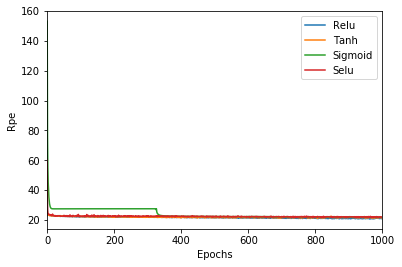

In [18]:
# Loss of the model

def plot_history(histories, key=  'rpe'):
  #plt.figure(figsize=(15,10))
    
  for name, history in histories:
    plt.plot(history.epoch, history.history[key],
             label=name.title())
    
  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()
  plt.xlim([0,max(history.epoch)])


plot_history([('relu', history_relu),
         
             ('tanh', history_tanh),
             ('sigmoid', history_sigmoid),
             ('selu', history_selu)])

In [19]:
#model_relu.layers[0].get_weights().shape

In [20]:
#Extract the weights of each model per layer:

w_relu = []
w_tanh = []
w_sigmoid=[]
w_selu=[]

for i in range(len(model_relu.layers)):
    #w_relu.append(max(model_relu.layers[i].get_weights()[1]))
    
    w_relu.append(model_relu.layers[0].get_weights()[1].max())
    w_tanh.append(model_tanh.layers[0].get_weights()[1].max())
    w_sigmoid.append(model_sigmoid.layers[0].get_weights()[1].max())
    w_selu.append(model_selu.layers[0].get_weights()[1].max())
    
    #w_tanh.append(max(model_tanh.layers[i].get_weights()[1]))

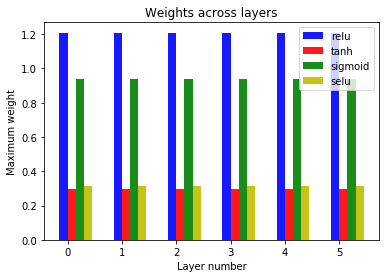

In [21]:
#Plot weight of both the models

fig, ax = plt.subplots()

index = np.arange(len(model_relu.layers))
bar_width = 0.15

plt.bar(index, w_relu, bar_width, label='relu', color='b', alpha=0.9)
plt.bar(index + bar_width, w_tanh, bar_width, label='tanh', color='r', alpha=0.9)
plt.bar(index + 2*bar_width, w_sigmoid, bar_width, label='sigmoid', color='g', alpha=0.9)
plt.bar(index + 3*bar_width, w_selu, bar_width, label='selu', color='y', alpha=0.9)
plt.title('Weights across layers')
plt.xlabel('Layer number')
plt.ylabel('Maximum weight')
plt.legend(loc=0)

plt.xticks(index + bar_width / 2, np.arange(8))
plt.show()